# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import random
import os
import pickle
from multiprocessing import Pool
import gzip
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

fonts = [os.path.abspath("fonts/" + f) for f in os.listdir('fonts')]
fonts

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


['/root/captcha_break/fonts/Huhtikuu.ttf',
 '/root/captcha_break/fonts/Chalkduster.ttf',
 '/root/captcha_break/fonts/Walk-Around.ttf',
 '/root/captcha_break/fonts/Courier New.ttf',
 '/root/captcha_break/fonts/Arial Bold.ttf',
 '/root/captcha_break/fonts/AgentRed.TTF',
 '/root/captcha_break/fonts/Arial.ttf',
 '/root/captcha_break/fonts/Chalkboard.ttc',
 '/root/captcha_break/fonts/Times New Roman.ttf']

# 定义数据生成器

In [4]:
from keras.utils.np_utils import to_categorical
from keras.utils import Sequence

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=fonts)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y
        
def gen_full(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    for i in tqdm(range(batch_size)):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[i] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1

def gen_pickles(batch_size=1,pickle_size=10000, dir='.'):
    X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    for i in tqdm(range(batch_size*pickle_size)):
        inner_idx, outer_idx = i % pickle_size, int(i/pickle_size)
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[inner_idx] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1
        if  inner_idx == pickle_size - 1:
            with gzip.open('%s/p-%d' % (dir, outer_idx ), "wb") as f:
                pickle.dump((X,y), f, True)
            X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
            y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]

def gen_one_pickle(seq=1,pickle_size=10000, dir='.'):
    X = np.zeros((pickle_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((pickle_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    for i in range(pickle_size):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        X[i] = generator.generate_image(random_str)
        for j, ch in enumerate(random_str):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1
    with gzip.open('%s/p-%d' % (dir, seq ), "wb") as f:
        pickle.dump((X,y), f, True)

def pickle_iter(batch_size, pickle_size, dir='.'):
    i = 0
    while True:
        i = i % batch_size
        print("pickle load dir %s, seq %d" % (dir, i) )
        with gzip.open("%s/p-%d" % (dir, i), 'rb' ) as f:
            X, y = pickle.load(f)
        i += 1
        yield X, y
    

def gen_file(batch_size=32, dir='.'):
    generator = ImageCaptcha(width=width, height=height)
    for i in tqdm(range(batch_size)):
        random_str = ''.join([random.choice(characters) for j in range(4)])
        generator.write(random_str, '%s/%s.png' % (dir,random_str))

def file_iter(batch_size=32, dir='.'):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    #dircache = os.
    files_set = set(os.listdir(dir))
    while True:
        for i in range(batch_size):
            filename = random.sample(files_set, 1)[0]
            files_set.remove(filename)
            img = Image.open('%s/%s' % (dir, filename))
            X[i] = np.asarray(img)
            img.close()
            for j, ch in enumerate(filename.split('.')[0]):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
            yield X, y
            
    


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 测试生成器

Text(0.5,1,'QzXr')

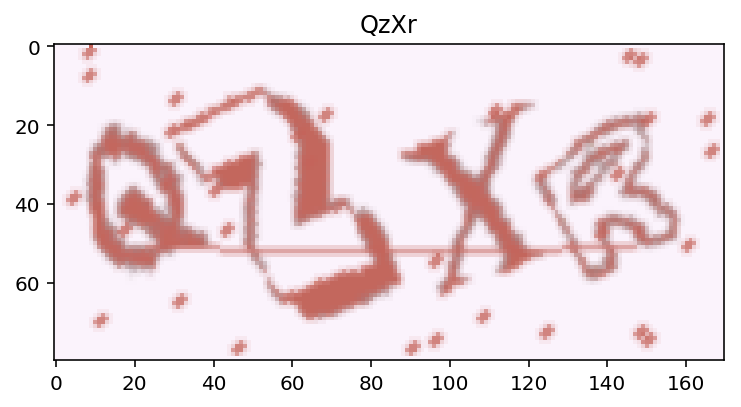

In [28]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
#X, y = next(file_iter(1, 'data/train'))
plt.imshow(X[0])
plt.title(decode(y))

In [11]:

#x_train, y_train = list(next(gen(500000)))
#x_test, y_test = list(next(gen(100000)))
#print('done')
#gen_pickle(1,10,'pickle/train')
#x_train, y_train = list(next(pickle_iter(1,10, 'pickle/train')))
#gen_file(1000000, 'data/train')
#pool = Pool(4)
#arg_lists = [(i,1000, 'data/train') for i in range(100)]
#pool.starmap(gen_one_pickle, arg_lists)

#pool = Pool(4)
#arg_lists = [(i,1000, 'pickle/train') for i in range(2000)]
#pool.starmap(gen_one_pickle, arg_lists)

#pool = Pool(4)
#arg_lists = [(i,1000, 'pickle/test') for i in range(400)]
#pool.starmap(gen_one_pickle, arg_lists)

#gen_file(200000, 'data/test')
#x_train, y_train = list(next(file_iter(100, 'data/train')))
#x_train2, y_train2 = gen_full(1000000)
#x_test2, y_test2 = gen_full(200000)


Process ForkPoolWorker-8:
Process ForkPoolWorker-5:


KeyboardInterrupt: 

Traceback (most recent call last):
Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda3/envs/fastai/lib/python3.6/multiprocessing/pool.py", line 47, in starmaps

# 定义网络结构

In [30]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
/root/anaconda3/envs/fastai/lib/python3.6/site-package

# 网络结构可视化

In [9]:
#from keras.utils.visualize_util import plot
#from IPython.display import Image

#plot(model, to_file="model.png", show_shapes=True)
#Image('model.png')

# 训练模型

In [10]:
class PickleSequenceData(Sequence):
    def __init__(self, path, batch_size):
        # path：存放所有图片的文件夹
        self.path = path
        self.batch_size = batch_size

    def __len__(self):
        # 让代码知道这个序列的长度
        return self.batch_size

    def __getitem__(self, i):
        # 迭代器部分
        #print("pickle load dir %s, seq %d" % (self.path, i) )
        with gzip.open("%s/p-%d" % (self.path, i), 'rb' ) as f:
            X, y = pickle.load(f)
        return X, y

In [11]:
#model.fit(x=x_train, y=y_train, epochs=10, batch_size=30,  
#                    validation_data=[x_test,y_test])

In [12]:
#model.fit_generator(file_iter(20,'data/train'), samples_per_epoch=50000, nb_epoch=5, 
#                    nb_worker=3, pickle_safe=True, 
#                    validation_data=file_iter(20,'data/test'), nb_val_samples=10000)
#model.fit_generator(pickle_iter(10, 1000,'pickle/train'), 
#                    validation_data=pickle_iter(2, 1000,'pickle/test'), steps_per_epoch=10, 
#                    epochs=3, validation_steps=2, workers=3, use_multiprocessing=True)

train_seq = PickleSequenceData('pickle/train', 2000)
test_seq = PickleSequenceData('pickle/test', 400)


model.fit_generator(train_seq, 
                    validation_data=test_seq, steps_per_epoch=2000, 
                    epochs=10, validation_steps=400, workers=4, use_multiprocessing=True)

#model.fit_generator(gen(20), 
 #                   validation_data=gen(20), steps_per_epoch=50000, 
 #                   epochs=5, validation_steps=10000, workers=3, use_multiprocessing=True)

Epoch 1/10
2000/2000 [==============================] - 1251s 626ms/step - loss: 2.8267 - c1_loss: 0.7644 - c2_loss: 0.6671 - c3_loss: 0.7194 - c4_loss: 0.6758 - c1_acc: 0.7964 - c2_acc: 0.8172 - c3_acc: 0.8056 - c4_acc: 0.8168 - val_loss: 0.1641 - val_c1_loss: 0.0320 - val_c2_loss: 0.0388 - val_c3_loss: 0.0477 - val_c4_loss: 0.0456 - val_c1_acc: 0.9877 - val_c2_acc: 0.9850 - val_c3_acc: 0.9818 - val_c4_acc: 0.9824
Epoch 2/10
2000/2000 [==============================] - 1245s 622ms/step - loss: 0.2383 - c1_loss: 0.0578 - c2_loss: 0.0574 - c3_loss: 0.0650 - c4_loss: 0.0581 - c1_acc: 0.9817 - c2_acc: 0.9812 - c3_acc: 0.9791 - c4_acc: 0.9813 - val_loss: 0.1204 - val_c1_loss: 0.0244 - val_c2_loss: 0.0303 - val_c3_loss: 0.0324 - val_c4_loss: 0.0333 - val_c1_acc: 0.9907 - val_c2_acc: 0.9883 - val_c3_acc: 0.9876 - val_c4_acc: 0.9874
Epoch 3/10
2000/2000 [==============================] - 1246s 623ms/step - loss: 0.1520 - c1_loss: 0.0359 - c2_loss: 0.0367 - c3_loss: 0.0419 - c4_loss: 0.0375 - 

# 测试模型

(-0.5, 169.5, 79.5, -0.5)

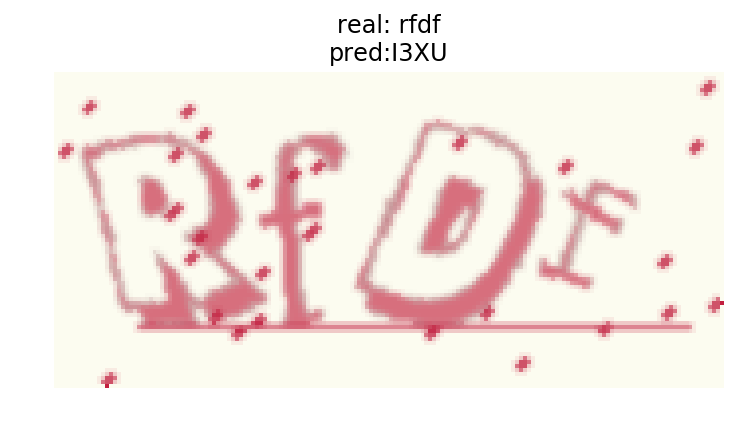

In [35]:
#model = load_model('cnn.h5')
#model.save('cnn_200w_epoch10.h5')
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [20]:
from tqdm import tqdm
def evaluate(model, batch_num=2000):
    batch_acc = 0
    generator = gen(1)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        if np.array_equal(y_true, y_pred):
            batch_acc += 1
    return batch_acc / batch_num


evaluate(model)

100%|██████████| 2000/2000 [00:08<00:00, 240.55it/s]


0.988

# 保存模型

In [18]:
model.save('cnn_200w_epoch10.h5')